In [1]:
import os, sys, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import hvplot.pandas
from bokeh.io import curdoc
import datetime


# curdoc().theme = "dark_minimal"

In [25]:
grade_conversion = {
    "6B+": 4,
    "6C" : 5,
    "6C+": 5.5,
    "7A" : 6,
    "7A+": 7,
    "7B" : 8,
    "7B+": 8.5
}

In [84]:
df = pd.read_csv("full_formatted_data_231213.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       491 non-null    object 
 1   name       491 non-null    object 
 2   grade      491 non-null    object 
 3   setter     491 non-null    object 
 4   mygrade    491 non-null    object 
 5   attempts   491 non-null    int64  
 6   ticked     491 non-null    bool   
 7   comment    3 non-null      object 
 8   grade_v    491 non-null    float64
 9   mygrade_v  491 non-null    float64
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 35.1+ KB


In [139]:
# Group by problem and report number of tries, if it is ticked or not, number of days, setter
from collections import namedtuple

def _groupby(raw_df, problem_sequence_df=None):
    
    def count_days(dt_series):
        return len(set(dt_series))
    
    df = raw_df[:]

    df.loc[:, "date"] = pd.to_datetime(df.date, format="%Y-%m-%d").dt.date

    df = raw_df.groupby(["name","grade_v", "setter"], as_index=False).aggregate(
        total_attempts = ("attempts", np.sum),
        total_days = ("date", count_days),
        ticked = ("ticked", np.any),
        last_tried = ("date", max),
        first_tried = ("date", min)
    )

    # TODO: Not sure how to do aggregating functions on groupby using multiple columns
    # e.g. passing in both 'date' and 'ticked' as inputs. until then.. using a loop and merge

    detailed_stats = []

    DateStats = namedtuple(
        "DateStats", 
        "name \
            first_ticked \
                attempts_to_send \
                    days_to_send \
                        num_repeats"
    )

    for n in df.name:
        first_ticked = np.nan
        tdf = raw_df[raw_df.name == n]
        ticked_sessions = tdf[tdf.ticked]
        
        try:
            first_ticked = ticked_sessions.date.min()
            attempts_to_send = tdf.loc[tdf.date<=first_ticked, "attempts"].sum()
            days_to_send = tdf.loc[tdf.date<=first_ticked].__len__()
        
        except Exception as e:
            print(e)
            first_ticked = np.nan
            attempts_to_send = np.nan
            days_to_send = np.nan

        num_repeats = ticked_sessions.__len__()
        
        detailed_stats.append(
            DateStats(n, first_ticked, attempts_to_send, days_to_send, num_repeats)
        )

    detailed_stats_df = pd.DataFrame(detailed_stats, columns=DateStats._fields)

    merged = pd.merge(left=df, right=detailed_stats_df, how='left', on='name')

    if problem_sequence_df is not None:
        merged = pd.merge(left=df, right=problem_sequence_df, how='left', on='name')

    return merged


def current_projects_ranked(raw_df, as_table=True):
    df = _groupby(raw_df)
    df = df[~df.ticked].sort_values(
        ["total_days", "total_attempts"], 
        ascending=False
    )
    df = df.drop(columns=['num_repeats', 'attempts_to_send', 'days_to_send', 'first_ticked', 'ticked'])
    
    df['last_tried_days'] = (datetime.date.today() - df.last_tried)
    df['span_days'] = (df.last_tried - df.first_tried)

    if as_table:
        return df.hvplot.table(sortable=True, selectable=True)

    return df

def ticked_climbs_ranked(
        raw_df,
        topk=10, 
        by=["attempts_to_send", "num_repeats"], 
        ascending=[False, True]
        ):
    # By default returns top ticked climbs ranked by most attempts needed, then by least repeats
    # good for choosing as repeats
    df = _groupby(raw_df)
    return df[df.ticked].sort_values(by=by, ascending=ascending).drop(columns='ticked')[:10]

# def ticked_climbs_ranked(raw_df, topk=10, by='attempts'):
    
#     # Get top-k list of climbs by difficulty
#     topk_climbs = raw_df.groupby(["name"], as_index=False).aggregate(
#         difficulty = ("grade_v", np.max)
#     ).loc[:topk, "name"]

#     topk_climbs = set(topk_climbs.tolist())
#     return topk_climbs

#     return df
    # return df[df.ticked].hvplot.table(sortable=True, selectable=True)



# df2[~df2.ticked].groupby("setter")




In [142]:
problem_sequences = pd.read_csv("hold_sequences.csv")
# names have a .
problem_sequences.loc[:, 'name'] = problem_sequences.name.apply(lambda x: x[:-1])
grp = _groupby(df, problem_sequence_df=problem_sequences)

In [143]:
grp

,name,grade_v,setter,total_attempts,total_days,ticked,last_tried,first_tried,sequence
0,#2 KH,5.5,Kyle Hilton,3,2,True,2022-10-06,2022-09-01,NaN
1,(*)(*)FAKE,4.0,Mystery Frog Man,1,1,True,2023-05-30,2023-05-30,"['F5', 'E8', 'H11', 'F15', 'D18']"
2,1,4.0,Hugo Hoyer,1,1,True,2023-11-26,2023-11-26,"['I5', 'F5', 'J8', 'G8', 'I10', 'K11', 'J13', ..."
3,1817,5.0,Randall Baum,3,1,False,2023-06-13,2023-06-13,"['K5', 'H5', 'F7', 'J10', 'E11', 'E13', 'B16',..."
4,1K,4.0,Bryant Noble,1,1,True,2023-11-28,2023-11-28,"['F5', 'G9', 'E10', 'G13', 'E15', 'D17', 'B18']"
...,...,...,...,...,...,...,...,...,...
232,¡APUNT****!,4.0,AJ Rimes,1,1,True,2023-12-12,2023-12-12,"['G2', 'B3', 'F5', 'E8', 'G9', 'E10', 'G13', '..."
233,紙一重 -KAMI HITOE-,5.5,seishirou shirai,6,1,True,2022-09-01,2022-09-01,NaN
234,課題2,5.5,atsushi takizawa,3,1,True,2023-02-16,2023-02-16,"['F5', 'E8', 'C10', 'G14', 'F15', 'I18']"
235,課題24,4.0,atsushi takizawa,1,1,True,2023-01-24,2023-01-24,"['F5', 'J8', 'B9', 'I10', 'E13', 'F14', 'B16',..."


In [147]:
df.name.str.replace(" ", "_")

0              POPIFRESCO
1           THE_SENDTRAIN
2                  BORNEO
3               BUTOLOGIA
4      FINGER_LICKIN_EASY
              ...        
486       AN_EASY_PROBLEM
487     WUTHERING_HEIGHTS
488                BITTER
489          KLINGON_EASY
490          FLASH_GORDON
Name: name, Length: 491, dtype: object

In [154]:
proj = current_projects_ranked(df, as_table=False)
# make name match sequences
proj.loc[:, "name"] = proj.name.str.replace(" ", "_")

proj = pd.merge(proj, problem_sequences, on='name', how='left')

In [ ]:
import ast
proj.loc[:, "sequence"] = proj.sequence.apply(ast.literal_eval)

In [167]:
proj = proj.dropna(subset='sequence')

from collections import Counter
from itertools import chain

counter_obj = Counter(chain.from_iterable(proj.sequence))

In [168]:
counter_obj.most_common()

[('D18', 13),
 ('E8', 10),
 ('H16', 9),
 ('J5', 8),
 ('K5', 6),
 ('E12', 6),
 ('G4', 6),
 ('H11', 5),
 ('F5', 5),
 ('F11', 5),
 ('I18', 5),
 ('H5', 5),
 ('F14', 4),
 ('G17', 4),
 ('E16', 4),
 ('H9', 4),
 ('I12', 4),
 ('A5', 4),
 ('E13', 4),
 ('J8', 4),
 ('G15', 4),
 ('K18', 4),
 ('K9', 3),
 ('I14', 3),
 ('I5', 3),
 ('H14', 3),
 ('E18', 3),
 ('G18', 3),
 ('C13', 3),
 ('A18', 3),
 ('G9', 3),
 ('H12', 3),
 ('E15', 3),
 ('K7', 2),
 ('C7', 2),
 ('E7', 2),
 ('A9', 2),
 ('E6', 2),
 ('B10', 2),
 ('F9', 2),
 ('D10', 2),
 ('F12', 2),
 ('G8', 2),
 ('B16', 2),
 ('G14', 2),
 ('J13', 2),
 ('H10', 2),
 ('K8', 2),
 ('K14', 2),
 ('I10', 2),
 ('D15', 2),
 ('C10', 2),
 ('K12', 1),
 ('D13', 1),
 ('A14', 1),
 ('B3', 1),
 ('C14', 1),
 ('C18', 1),
 ('D9', 1),
 ('K11', 1),
 ('J16', 1),
 ('K6', 1),
 ('F15', 1),
 ('F10', 1),
 ('J7', 1),
 ('I4', 1),
 ('B13', 1),
 ('D16', 1),
 ('F7', 1),
 ('J10', 1),
 ('E11', 1),
 ('C12', 1),
 ('D5', 1),
 ('B8', 1),
 ('E10', 1),
 ('E14', 1),
 ('F13', 1),
 ('G13', 1),
 ('I15', 1),

In [233]:
from image_to_vector import find_edges, BoardCoor
from typing import List
import skimage
import cv2

def make_heatmap_of_holds(problems: List[np.ndarray], blank: np.ndarray) -> np.ndarray:
    def minmax(img):
        return (((img-np.min(img)) / (img.max() - img.min())) * 255).astype(np.uint8)
    
    # TODO: Hardcoded based on the blank board screenshot. May need to adjust x,y
    board_background_colour = np.linalg.norm(blank, axis=2)[700,40]
    bc = find_edges(blank, board_background_colour)
    # _logger.info(f'{bc}, {board_background_colour}')
    blank = blank[bc.ymin:bc.ymax, bc.xmin:bc.xmax]
    
    matched_binaries = []

    for img in problems:
        bc_img = find_edges(img, board_background_colour)
        img_board = img[bc_img.ymin:bc_img.ymax, bc_img.xmin:bc_img.xmax]
        # resize to match blank - Crop to hardcoded evenly spaced bolt sizes
        img_board = skimage.transform.resize(img_board, blank.shape)
        # Find differences (circles..)
        matched = np.logical_and(img_board, blank).astype(float)
        m = matched.sum(axis=(-1)) == 4
        m = skimage.morphology.area_closing(m, area_threshold=100)
        
        
        matched_binaries.append((~m).astype(int))

    stacked_gray = minmax(np.sum(np.dstack(matched_binaries), axis=-1))
    blank_gray = skimage.color.rgb2gray(blank[..., :3])
    # blank_gray = np.dstack(blank_gray)


    stacked_heatmap = cv2.applyColorMap(stacked_gray, cv2.COLORMAP_JET)
    plt.imshow(blank_gray, cmap='gray')
    plt.imshow(stacked_heatmap, cmap='jet', alpha=0.5)
    return stacked_heatmap
    print(stacked_heatmap.shape, blank.shape)

    stacked_heatmap = cv2.addWeighted(stacked_heatmap, 0.5, (blank[..., :3]*255).astype(np.uint8), 0.5, 0)
    # stacked_rgba = np.dstack([
    #     np.ones_like(stacked_gray),
    #     np.zeros_like(stacked_gray),
    #     np.zeros_like(stacked_gray),
    #     stacked_gray
    # ])

    return stacked_heatmap            

    
    
    
    return matched_binaries

imgs = []
for i, fp in enumerate(os.listdir("images")):
    fpp = os.path.join("images", fp)
    imgs.append(plt.imread(fpp))
    if i==10:
        break
base = plt.imread("blank_MB.png")



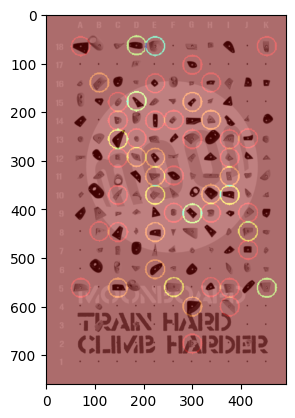

In [234]:
matched = make_heatmap_of_holds(imgs, base)

In [206]:

np.unique(minmax(matched))

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 1.        ])

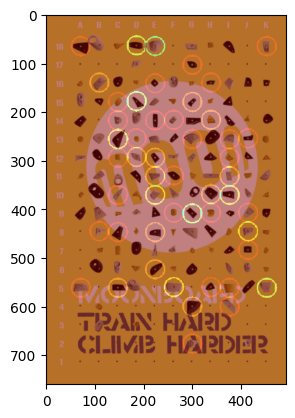

In [228]:
plt.imshow(matched)

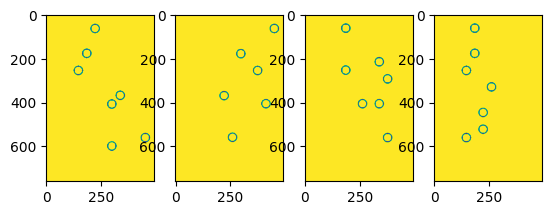

In [195]:
fig, ax = plt.subplots(ncols=4)
for i in range(4):
    ax[i].imshow(matched[i])

In [197]:
m = matched[0]
np.unique(m)
m[0,0]

True

In [129]:
ticked_climbs_ranked(df)

,name,grade_v,setter,total_attempts,total_days,last_tried,first_tried,first_ticked,attempts_to_send,days_to_send,num_repeats
23,ASTRO CREEP,4.0,Jonny Summers,46,7,2023-11-21,2022-11-17,2023-11-21,46,7,1
153,POGO,6.0,luke hutcheson,16,4,2023-07-13,2023-03-23,2023-06-17,14,4,2
113,IMPROVVISAZIONE,6.0,Jean-Pierre Bovo,13,3,2022-12-08,2022-11-17,2022-12-08,13,3,1
140,NORTHSIDE,6.0,Matt Mcnair,13,4,2023-02-21,2022-12-08,2023-02-21,13,4,1
175,SHAKEDOWN STREET,5.5,Matt Poiesz,13,4,2022-11-15,2022-10-26,2022-11-15,13,4,1
134,MOON CASTLE,5.0,Ben Moon,12,5,2023-02-26,2022-09-10,2023-02-26,12,5,1
213,VIVA,4.0,Hakan Ertekin,12,3,2023-01-19,2022-12-15,2023-01-19,12,4,1
161,RAINY DAY,4.0,Chris Tibbals,12,3,2023-02-26,2023-02-16,2023-02-26,12,4,2
146,OVN,5.0,Jørgen Bryn Henriksen,10,5,2022-11-15,2022-10-01,2022-11-15,10,5,1
177,SISÚ,5.0,edu moya,10,4,2023-05-06,2023-03-02,2023-05-06,10,4,1


In [44]:
proj = current_projects_ranked(df)

In [91]:
proj

:Table   [name,grade_v,setter,total_attempts,total_days,ticked,last_tried,first_tried,date_first_ticked,attempts_to_send,days_to_send,num_repeats]

In [54]:
ticked = ticked_climbs_ranked(df)

In [55]:
ticked

{'#2 KH',
 '(*)(*)FAKE',
 '1',
 '1817',
 '1K',
 '2',
 '272966',
 '7A TOO MUCH',
 '7STÖCKE',
 'A LITTLE CROSSING',
 'AB1'}

In [137]:
# Havce a look at the hold sequences generated by CV hacky script

hs = pd.read_csv("hold_sequences.csv")
hs.head()
hs.loc[:, 'name'] = hs.name.apply(lambda x: x[:-1])

In [138]:
pd.merge(left=df, right=hs, on='name')

,date,name,grade,setter,mygrade,attempts,ticked,comment,grade_v,mygrade_v,sequence
0,2023-12-14,POPIFRESCO,6B+,JAVIERMENG,6B+,2,False,NaN,4.0,4.0,"['G2', 'E6', 'G9', 'C10', 'C13', 'D15', 'D18']"
1,2023-05-07,POPIFRESCO,6B+,JAVIERMENG,6B+,2,True,NaN,4.0,4.0,"['G2', 'E6', 'G9', 'C10', 'C13', 'D15', 'D18']"
2,2023-12-14,BORNEO,7A,Stuart Ivory,6C+,1,True,NaN,6.0,5.5,"['G2', 'E6', 'G9', 'I10', 'J13', 'G15', 'G17',..."
3,2023-12-12,BORNEO,7A,Stuart Ivory,6C+,6,True,NaN,6.0,5.5,"['G2', 'E6', 'G9', 'I10', 'J13', 'G15', 'G17',..."
4,2023-12-14,BUTOLOGIA,6C,nicholas farenzena,6C,1,True,NaN,5.0,5.0,"['F5', 'J9', 'E10', 'I13', 'G15', 'K18']"
...,...,...,...,...,...,...,...,...,...,...,...
143,2022-09-29,DSTYLE,6B+,hamad_climbs,6B+,1,True,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"
144,2022-09-18,DSTYLE,6B+,hamad_climbs,6B+,2,True,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"
145,2022-09-08,DSTYLE,6B+,hamad_climbs,6B+,1,False,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"
146,2022-08-30,DSTYLE,6B+,hamad_climbs,6B+,1,True,NaN,4.0,4.0,"['F5', 'E8', 'C10', 'F11', 'F14', 'G18']"


In [153]:
for n in problem_sequences.name:
    if "WREK" in n:
        print(n)

In [238]:
current_projects_ranked(df, as_table=False).to_csv("current_projects.csv")
ticked_climbs_ranked(df).to_csv("ticked_by_hardest.csv")

# Bringing things together
- Scrape garmin and MB data from latest date (find from csv locations)
- Prompt for a 'last n weeks' parameter (e.g. 8 weeks back)
- Generate mb tables
    - Current projects
    -  

In [1]:
from pull_garmin_data import pull_workout_data_from_date
from main import Scraper, find_existing_date
import datetime
import pandas as pd


In [2]:
GARMIN_STRENGTH_LOG = "./data/garmin_strength_log.csv"
MB_LOG = "./data/mb_log.csv"
BLOCK_START = "2023-11-20"  # This is week 1 of block, monday

In [3]:
# existing_strength_df, last_date = find_existing_date(GARMIN_STRENGTH_LOG)
# from_date = (last_date + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
garmin_df = pull_workout_data_from_date(as_dataframe=True, n_most_recent_activities=9999)
# garmin_df.to_csv(GARMIN_STRENGTH_LOG)


Connected with id: 8062e2eb-97b8-416a-9c4a-12c62d3aea2a
Found 33 logged exercises across 33 days since 1999-01-01
UNKNOWN not found in mappings, adding as is..
SQUAT not found in mappings, adding as is..
SQUAT not found in mappings, adding as is..
UNKNOWN not found in mappings, adding as is..
UNKNOWN not found in mappings, adding as is..
UNKNOWN not found in mappings, adding as is..


In [7]:
set(garmin_df.ename.to_list())

{'HB: IMR 20mm', 'HB: SC 20mm', 'benchpress', 'deadlift', 'weighted pull up'}

In [8]:
# Lets add in the reflex logs
rdf = (pd.read_csv("./data/reflex_exercise_log_full.csv").drop(columns="Unnamed: 0")
       .rename(columns={"reps":"ereps"}))
rdf.head()
rdf.loc[:, "date"] = pd.to_datetime(rdf.date, format="%d-%m-%y")
rdf.loc[:, "duration"] = 30
rdf.loc[rdf.ename=='weighted pull-up', 'ename'] = 'weighted pull up'


/tmp/ipykernel_54171/1486218937.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  rdf.loc[:, "date"] = pd.to_datetime(rdf.date, format="%d-%m-%y")


In [13]:
strength_df = pd.concat([rdf[["date", "ename", "ereps", "kg", "duration"]], garmin_df])
strength_df.sort_values(by='date', ascending=False, inplace=True)
strength_df

,date,ename,ereps,kg,duration
0,2024-01-08,HB: IMR 20mm,1,62.0,10.0
1,2024-01-08,HB: IMR 20mm,1,62.0,10.0
2,2024-01-08,HB: IMR 20mm,2,62.0,10.0
3,2024-01-08,HB: IMR 20mm,1,62.0,10.0
4,2024-01-08,HB: IMR 20mm,1,62.0,10.0
...,...,...,...,...,...
6,2023-09-20,benchpress,6,60.0,30.0
5,2023-09-20,benchpress,6,60.0,30.0
4,2023-09-18,benchpress,6,60.0,30.0
3,2023-09-18,benchpress,6,60.0,30.0


In [14]:
# Save the combined CSV (Initial table build up)
strength_df.to_csv(GARMIN_STRENGTH_LOG, index=False)

## Table of exercises by week reporting frequency etc..

- Takes as input the date of the first week of the block (or as far back as wanted)
- Reports on weeks until present day


In [116]:
start_dt = datetime.datetime.strptime(BLOCK_START, "%Y-%m-%d")
end_dt = datetime.date.today()
end_dt += datetime.timedelta(days=(7-datetime.date.today().weekday())) # Round to monday
bins_dt = pd.date_range(start=start_dt, end=end_dt, freq="7D")
bin_labels = [f"Week {i+1} ({dt.strftime('%d %b')})" for i,dt in enumerate(bins_dt[:-1])]
bins_dt, bin_labels

(DatetimeIndex(['2023-11-20', '2023-11-27', '2023-12-04', '2023-12-11',
                '2023-12-18', '2023-12-25', '2024-01-01', '2024-01-08',
                '2024-01-15'],
               dtype='datetime64[ns]', freq='7D'),
 ['Week 1 (20 Nov)',
  'Week 2 (27 Nov)',
  'Week 3 (04 Dec)',
  'Week 4 (11 Dec)',
  'Week 5 (18 Dec)',
  'Week 6 (25 Dec)',
  'Week 7 (01 Jan)',
  'Week 8 (08 Jan)'])

In [117]:
strength_df['dt_cut'] = pd.cut(strength_df['date'],
                               bins=bins_dt,
                               labels=bin_labels,
                               right=False,
                               include_lowest=True)
def calc_load(df, tut_to_rep_mapping={'HB: SC 20mm': 2.5, 'HB: IMR 20mm': 2.5}):
    df.loc[:, 'rep_load'] = df.ereps * df.kg
    tut_only = df.ename.isin(tut_to_rep_mapping.keys())
    df.loc[tut_only, "rep_load"] = df.loc[tut_only].apply(
        lambda row: (row.duration / tut_to_rep_mapping[row.ename]) * row.kg,
        axis=1
    )
    return df

# Filter out by name, kg, etc. To filter out 'no hangs'
def filter_df(
        df: pd.DataFrame, 
        exclude_names=[], 
        min_kg=0, 
        max_duration=30,
        rename_nohangs=True
        ):
    df.loc[df.duration > max_duration, "duration"] = 30
    if rename_nohangs:
        df.loc[((df.ename == "HB: IMR 20mm") | (df.ename == "HB: SC 20mm")) 
               & (df.kg == 62), "ename"] = "no hangs"
        
    return df[(~df.ename.isin(exclude_names)) & (df.kg>min_kg)]

df2 = filter_df(strength_df, min_kg=0)
df2 = calc_load(df2)
df2

,date,ename,ereps,kg,duration,dt_cut,rep_load
0,2023-10-04,deadlift,5,70.0,30.0,NaN,350.0
1,2023-10-04,deadlift,3,130.0,30.0,NaN,390.0
2,2023-09-18,benchpress,6,60.0,30.0,NaN,360.0
3,2023-09-18,benchpress,6,60.0,30.0,NaN,360.0
4,2023-09-18,benchpress,6,60.0,30.0,NaN,360.0
...,...,...,...,...,...,...,...
53,2023-12-16,no hangs,1,62.0,10.0,Week 4 (11 Dec),62.0
54,2023-12-16,no hangs,1,62.0,10.0,Week 4 (11 Dec),62.0
55,2023-12-16,no hangs,1,62.0,10.0,Week 4 (11 Dec),62.0
56,2023-12-16,no hangs,1,62.0,10.0,Week 4 (11 Dec),62.0


<Axes: xlabel='dt_cut', ylabel='kg'>

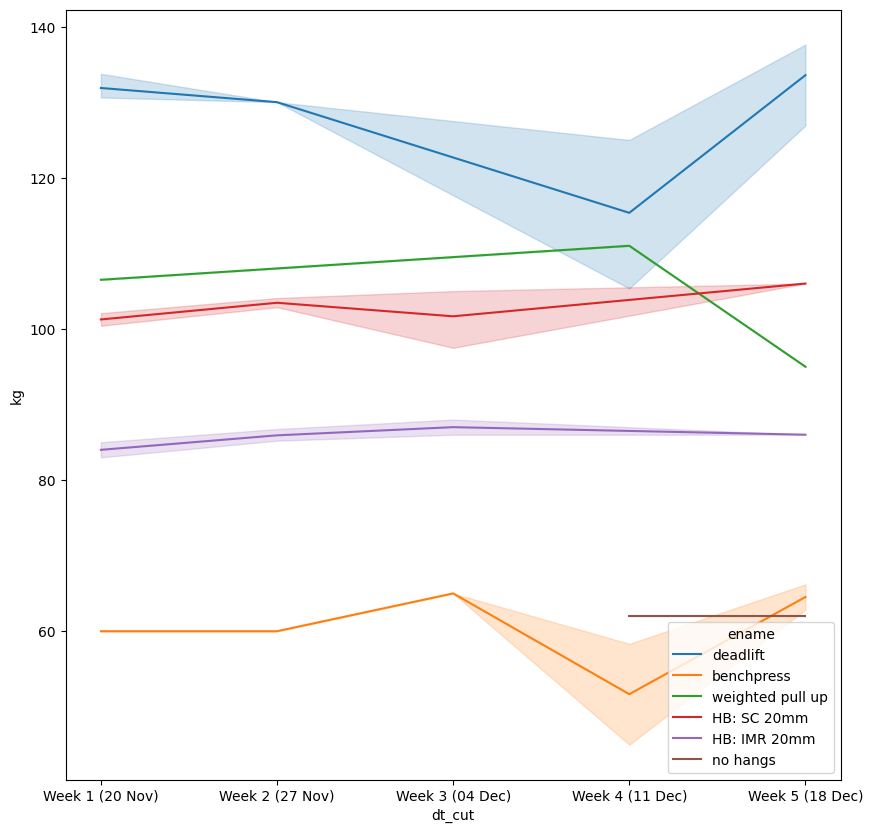

In [118]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.lineplot(data=df2, x='dt_cut', y='kg', hue='ename')

In [68]:
# Filter out exercises outside block range
df2 = df2.dropna(subset="dt_cut")

In [73]:
grp = df2.groupby(['dt_cut', 'ename']).aggregate(
    volume_reps = ('ereps', sum),
    volume_time = ('duration', sum),
    max_kg = ('kg', max),
    accum_load = ('rep_load', sum),
    sessions = ('date', 'nunique')    
).fillna(0)
grp

volume_reps  volume_time  max_kg  \
dt_cut          ename                                                
Week 1 (20 Nov) HB: IMR 20mm               70      210.000    86.0   
                HB: SC 20mm                55      180.000   102.5   
                benchpress                 25      240.000    60.0   
                deadlift                   21      240.000   135.0   
                no hangs                    0        0.000     0.0   
                weighted pull up           15      150.000   106.5   
Week 2 (27 Nov) HB: IMR 20mm               54      180.000    87.5   
                HB: SC 20mm                60      180.000   105.0   
                benchpress                 17      120.000    60.0   
                deadlift                   20      180.000   130.0   
                no hangs                    0        0.000     0.0   
                weighted pull up            0        0.000     0.0   
Week 3 (04 Dec) HB: IMR 20mm               30       90.000    88.0   
                HB: SC 20mm                30       90.000   105.0   
                benchpress                  9       90.000    65.0   
                deadlift                    0        0.000     0.0   
                no hangs                    0        0.000     0.0   
                weighted pull up            0        0.000     0.0   
Week 4 (11 Dec) HB: IMR 20mm                0        0.000     0.0   
                HB: SC 20mm                 0        0.000     0.0   
                benchpress                 11        0.000    65.0   
                deadlift                    9       83.703   135.0   
                no hangs                    8       80.000    62.0   
                weighted pull up            9       90.000   111.0   
Week 5 (18 Dec) HB: IMR 20mm                3       30.000    86.0   
                HB: SC 20mm                 3       30.000   106.0   
                benchpress                  0        0.000     0.0   
                deadlift                   12       85.359   135.0   
                no hangs                   33      320.000    62.0   
                weighted pull up            0        0.000     0.0   
Week 6 (25 Dec) HB: IMR 20mm                0        0.000     0.0   
                HB: SC 20mm                 0        0.000     0.0   
                benchpress                  0        0.000     0.0   
                deadlift                    0        0.000     0.0   
                no hangs                    0        0.000     0.0   
                weighted pull up            0        0.000     0.0   

                                  accum_load  sessions  
dt_cut          ename                                   
Week 1 (20 Nov) HB: IMR 20mm          7056.0         2  
                HB: SC 20mm           7290.0         2  
                benchpress            1500.0         2  
                deadlift              2765.0         2  
                no hangs                 0.0         0  
                weighted pull up      1597.5         1  
Week 2 (27 Nov) HB: IMR 20mm          6186.0         2  
                HB: SC 20mm           7449.0         2  
                benchpress            1020.0         1  
                deadlift              2600.0         2  
                no hangs                 0.0         0  
                weighted pull up         0.0         0  
Week 3 (04 Dec) HB: IMR 20mm          3132.0         1  
                HB: SC 20mm           3660.0         1  
                benchpress             585.0         1  
                deadlift                 0.0         0  
                no hangs                 0.0         0  
                weighted pull up         0.0         0  
Week 4 (11 Dec) HB: IMR 20mm             0.0         0  
                HB: SC 20mm              0.0         0  
                benchpress             715.0         1  
                deadlift              1215.0         1  
     

In [74]:
grp.loc[("Week 5 (18 Dec)", "no hangs"), :]

volume_reps      33.0
volume_time     320.0
max_kg           62.0
accum_load     2046.0
sessions          4.0
Name: (Week 5 (18 Dec), no hangs), dtype: float64

In [97]:
grp.unstack(level=-1)

volume_reps                                           \
ename           HB: IMR 20mm HB: SC 20mm benchpress deadlift no hangs   
dt_cut                                                                  
Week 1 (20 Nov)           70          55         25       21        0   
Week 2 (27 Nov)           54          60         17       20        0   
Week 3 (04 Dec)           30          30          9        0        0   
Week 4 (11 Dec)            0           0         11        9        8   
Week 5 (18 Dec)            3           3          0       12       33   
Week 6 (25 Dec)            0           0          0        0        0   

                                  volume_time                                  \
ename           weighted pull up HB: IMR 20mm HB: SC 20mm benchpress deadlift   
dt_cut                                                                          
Week 1 (20 Nov)               15        210.0       180.0      240.0  240.000   
Week 2 (27 Nov)                0        180.0       180.0      120.0  180.000   
Week 3 (04 Dec)                0         90.0        90.0       90.0    0.000   
Week 4 (11 Dec)                9          0.0         0.0        0.0   83.703   
Week 5 (18 Dec)                0         30.0        30.0        0.0   85.359   
Week 6 (25 Dec)                0          0.0         0.0        0.0    0.000   

                 ... accum_load                                     \
ename            ... benchpress deadlift no hangs weighted pull up   
dt_cut           ...                                                 
Week 1 (20 Nov)  ...     1500.0   2765.0      0.0           1597.5   
Week 2 (27 Nov)  ...     1020.0   2600.0      0.0              0.0   
Week 3 (04 Dec)  ...      585.0      0.0      0.0              0.0   
Week 4 (11 Dec)  ...      715.0   1215.0    496.0            999.0   
Week 5 (18 Dec)  ...        0.0   1620.0   2046.0              0.0   
Week 6 (25 Dec)  ...        0.0      0.0      0.0              0.0   

                    sessions                                           \
ename           HB: IMR 20mm HB: SC 20mm benchpress deadlift no hangs   
dt_cut                                                                  
Week 1 (20 Nov)            2           2          2        2        0   
Week 2 (27 Nov)            2           2          1        2        0   
Week 3 (04 Dec)            1           1          1        0        0   
Week 4 (11 Dec)            0           0          1        1        1   
Week 5 (18 Dec)            1           1          0        1        4   
Week 6 (25 Dec)            0           0          0        0        0   

                                  
ename           weighted pull up  
dt_cut                            
Week 1 (20 Nov)                1  
Week 2 (27 Nov)                0  
Week 3 (04 Dec)                0  
Week 4 (11 Dec)                1  
Week 5 (18 Dec)                0  
Week 6 (25 Dec)                0  

[6 rows x 30 columns]

array([[<Axes: title={'center': '(sessions, HB: IMR 20mm)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, HB: SC 20mm)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, benchpress)'}, xlabel='dt_cut'>],
       [<Axes: title={'center': '(sessions, deadlift)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, no hangs)'}, xlabel='dt_cut'>,
        <Axes: title={'center': '(sessions, weighted pull up)'}, xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes: xlabel='dt_cut'>],
       [<Axes: xlabel='dt_cut'>, <Axes: xlabel='dt_cut'>,
        <Axes

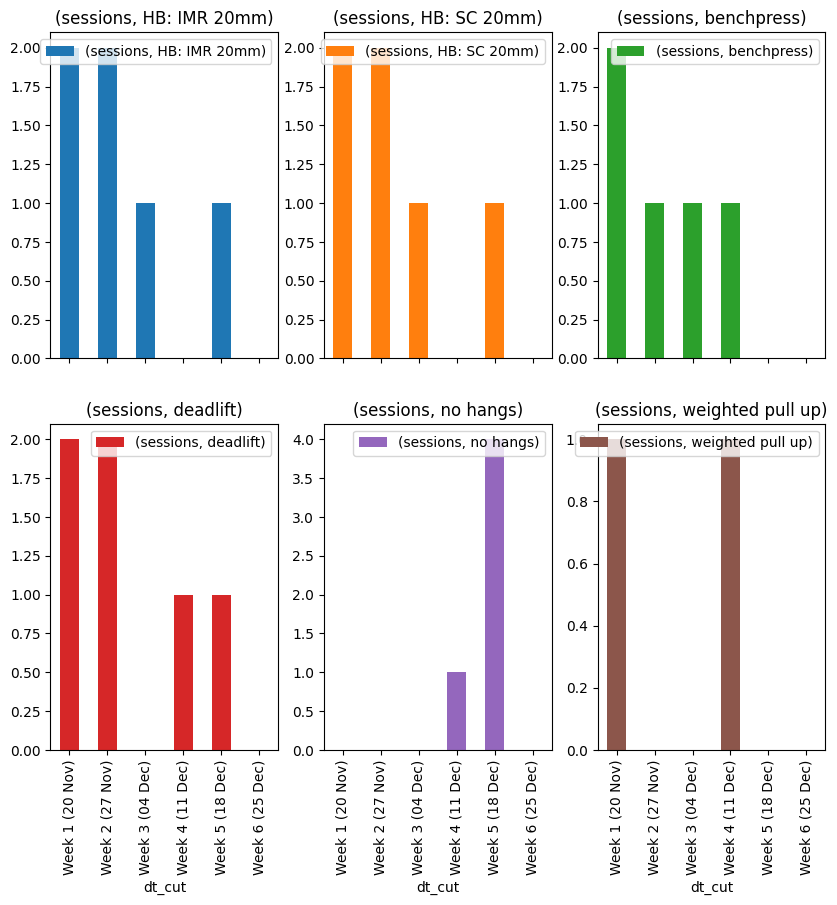

In [101]:
# grp.unstack(level=-1)[['sessions']].plot(rot=90, subplots=True, marker='x', linestyle="", figsize=(10,50), layout=(10,3))
grp.unstack(level=-1)[['sessions']].plot(kind='bar', rot=90, subplots=True, figsize=(10,50), layout=(10,3))

In [109]:
# Plots

# Sessions per week
grp.unstack(level=-1)['sessions'].T.plot(kind='pie', subplots=True, figsize=(50,50))

/home/matt/venvs/moonplot/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3193: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 5000x5000 with 6 Axes>